In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/test_file/test.csv_yAFwdy2.zip
!wget https://datahack-prod.s3.amazonaws.com/train_file/train.csv_VsW9EGx.zip
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_iA3afxn.csv

--2020-09-20 17:18:19--  https://datahack-prod.s3.amazonaws.com/test_file/test.csv_yAFwdy2.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.88
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1539177 (1.5M) [application/zip]
Saving to: ‘test.csv_yAFwdy2.zip’

test.csv_yAFwdy2.zi 100%[===================>]   1.47M   920KB/s    in 1.6s    

2020-09-20 17:18:22 (920 KB/s) - ‘test.csv_yAFwdy2.zip’ saved [1539177/1539177]

--2020-09-20 17:18:22--  https://datahack-prod.s3.amazonaws.com/train_file/train.csv_VsW9EGx.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.64
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4667725 (4.5M) [application/zip]
Saving to: ‘train.csv_VsW9EGx.zip’


In [ ]:
!unzip test.csv_yAFwdy2.zip
!unzip train.csv_VsW9EGx.zip

Archive:  test.csv_yAFwdy2.zip
  inflating: test.csv                
Archive:  train.csv_VsW9EGx.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn import svm
import xgboost

     |████████████████████████████████| 163kB 6.2MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-cp36-none-any.whl size=10261 sha256=6ee1fedf2116fda4eb647b9a85574c110e3be84712556601394707986793a2f2
  Stored in directory: /root/.cache/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Created wheel for stratx: filename=stratx-0.5-cp36-none-any.whl size=35033 sha256=e5f0c7fe0a3c2e394d4704951d97d28b2161f6c40ee4aaeb30d94c403c96ad7d
  Stored in directory: /root/.cache/pip/wheels/6e/28/de/a84563cfe761afd6c628e595590455412e26a6c4d587289d7b
Successfully built rfpimp stratx
     |████████████████████████████████| 66.1MB 49kB/s 


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
test.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(id                      0
 Gender                  0
 Age                     0
 Driving_License         0
 Region_Code             0
 Previously_Insured      0
 Vehicle_Age             0
 Vehicle_Damage          0
 Annual_Premium          0
 Policy_Sales_Channel    0
 Vintage                 0
 Response                0
 dtype: int64, id                      0
 Gender                  0
 Age                     0
 Driving_License         0
 Region_Code             0
 Previously_Insured      0
 Vehicle_Age             0
 Vehicle_Damage          0
 Annual_Premium          0
 Policy_Sales_Channel    0
 Vintage                 0
 dtype: int64, (381109, 12), (127037, 11), id                        int64
 Gender                   object
 Age                       int64
 Driving_License           int64
 Region_Code             float64
 Previously_Insured        int64
 Vehicle_Age              object
 Vehicle_Damage           object
 Annual_Premium          float64
 Policy_Sales_Channel    f

In [ ]:
df=pd.concat([train,test])

In [ ]:
from sklearn.preprocessing import LabelEncoder
x=['Vehicle_Damage','Vehicle_Age','Gender']
for i in x:
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])
  df[i]=df[i]+1

In [ ]:
df = pd.get_dummies(df, columns=['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage'])

In [ ]:
train = df[df['Response'].isnull()==False]
test = df[df['Response'].isnull()==True]
del test['Response']

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
from math import sqrt 
from sklearn.metrics import roc_auc_score

#ot

In [ ]:
X = train_df.drop(labels=['Response'], axis=1)
y = train_df['Response'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((342998, 17), (342998,), (38111, 17), (38111,))

In [ ]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(#loss_function='CrossEntropy', 
                         eval_metric='AUC', 
                         #classes_count=2,
                         depth=3,
                         random_seed=121, 
                         iterations=1000, 
                         learning_rate=0.4,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)
predictions = cat.predict(X_cv)
print('accuracy:', roc_auc_score(y_cv, predictions))

0:	test: 0.8127883	test1: 0.8160402	best: 0.8160402 (0)	total: 71.9ms	remaining: 1m 11s
100:	test: 0.8581159	test1: 0.8588527	best: 0.8588527 (100)	total: 7.92s	remaining: 1m 10s
200:	test: 0.8600844	test1: 0.8593497	best: 0.8594319 (180)	total: 15.8s	remaining: 1m 2s
300:	test: 0.8611552	test1: 0.8594654	best: 0.8595188 (294)	total: 23.6s	remaining: 54.9s
400:	test: 0.8621193	test1: 0.8593744	best: 0.8595188 (294)	total: 31.5s	remaining: 47.1s
500:	test: 0.8628066	test1: 0.8591732	best: 0.8595188 (294)	total: 39.5s	remaining: 39.3s
600:	test: 0.8633867	test1: 0.8590266	best: 0.8595188 (294)	total: 47.3s	remaining: 31.4s
700:	test: 0.8639677	test1: 0.8588800	best: 0.8595188 (294)	total: 55.1s	remaining: 23.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8595187654
bestIteration = 294

Shrink model to first 295 iterations.
accuracy: 0.5088503781536582


In [ ]:
print('accuracy:', roc_auc_score(y_cv, predictions, average='weighted'))

accuracy: 0.5088503781536582


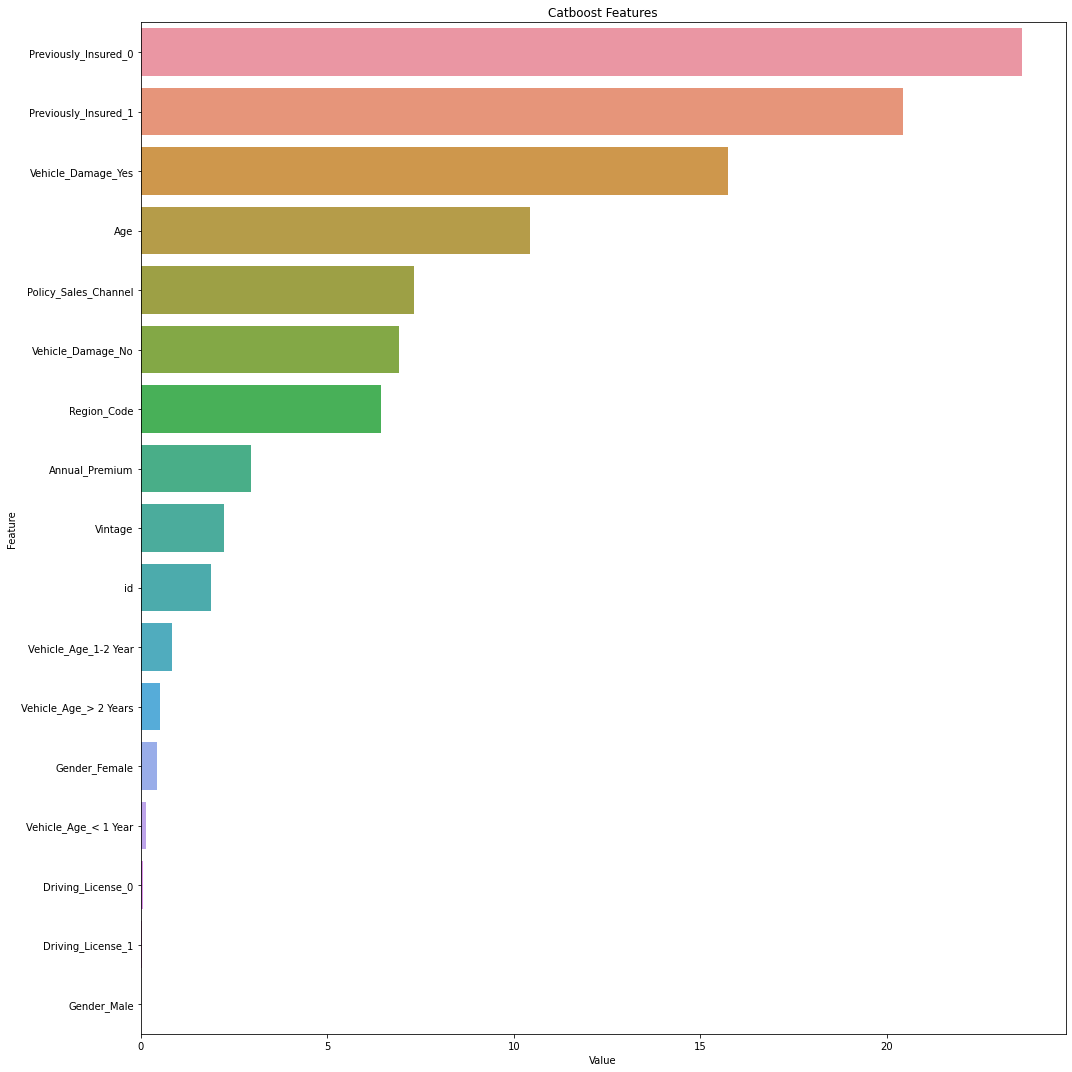

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='AUC', 
                         classes_count=3,
                         depth=6,
                         random_seed=121, 
                         iterations=100, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.8, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", roc_auc_score(y_test,y_pred_cat, average='weighted'))

    errcat.append(roc_auc_score(y_test,y_pred_cat, average='weighted'))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5004665980019541


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5005431252473324


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5007004251423874


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5007404273323461


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5007254157541721


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5007118649635723


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5007892616701533


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5004943375565382


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5007686061026468


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


Accuracy:  0.5004092862412466


In [ ]:
np.mean(errcat,0)

0.500634934801235

In [ ]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
xxx = pd.DataFrame(data=cat_final, columns=['zeb'])

In [ ]:
submission = pd.DataFrame({
        "id":test['id'],
        "Response": xxx['zeb']
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

            id  Response
0       381110         0
1       381111         0
2       381112         0
3       381113         0
4       381114         0
...        ...       ...
127032  508142         0
127033  508143         0
127034  508144         0
127035  508145         0
127036  508146         0

[127037 rows x 2 columns]


#up

In [ ]:
X = train_df.drop(labels=['Response'], axis=1)
y = train_df['Response'].values
scale = StandardScaler()
X = scale.fit_transform(X)
test = scale.transform(test)

In [ ]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [ ]:
from catboost import CatBoostClassifier, Pool
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)
eval_dataset = Pool(x_test,
                    y_test)
model = CatBoostClassifier(learning_rate=0.02,iterations=800,depth=8,
                           eval_metric='AUC',task_type="GPU",devices='0:1')

model.fit(x_train,
          y_train,
          eval_set=eval_dataset,
          verbose=True)

0:	learn: 0.8450354	test: 0.8456914	best: 0.8456914 (0)	total: 29.3ms	remaining: 23.4s
1:	learn: 0.8450322	test: 0.8458610	best: 0.8458610 (1)	total: 57.6ms	remaining: 23s
2:	learn: 0.8471089	test: 0.8476322	best: 0.8476322 (2)	total: 85.9ms	remaining: 22.8s
3:	learn: 0.8476742	test: 0.8485316	best: 0.8485316 (3)	total: 114ms	remaining: 22.7s
4:	learn: 0.8480925	test: 0.8488346	best: 0.8488346 (4)	total: 143ms	remaining: 22.7s
5:	learn: 0.8479105	test: 0.8487599	best: 0.8488346 (4)	total: 171ms	remaining: 22.7s
6:	learn: 0.8479196	test: 0.8487795	best: 0.8488346 (4)	total: 199ms	remaining: 22.6s
7:	learn: 0.8485159	test: 0.8496261	best: 0.8496261 (7)	total: 228ms	remaining: 22.5s
8:	learn: 0.8485199	test: 0.8495919	best: 0.8496261 (7)	total: 253ms	remaining: 22.2s
9:	learn: 0.8485787	test: 0.8497576	best: 0.8497576 (9)	total: 281ms	remaining: 22.2s
10:	learn: 0.8487107	test: 0.8498762	best: 0.8498762 (10)	total: 309ms	remaining: 22.1s
11:	learn: 0.8486185	test: 0.8498078	best: 0.849876

In [ ]:
model.get_feature_importance()

array([ 5.93080383, 11.23245986,  9.10480605,  8.78077241,  7.66319306,
        6.79885126,  2.08417853,  2.69767789,  0.05335141,  0.02318863,
       17.45596584, 15.20255499,  1.76381488,  1.34220938,  0.24280281,
        4.43866962,  5.18469956])

In [ ]:
y_probs = model.predict_proba(test_df)
y_probs

array([[0.93723352, 0.06276648],
       [0.83671546, 0.16328454],
       [0.83671546, 0.16328454],
       ...,
       [0.93723352, 0.06276648],
       [0.97623886, 0.02376114],
       [0.97623886, 0.02376114]])

In [ ]:
x = y_probs[:,1]
x

array([0.06276648, 0.16328454, 0.16328454, ..., 0.06276648, 0.02376114,
       0.02376114])

In [ ]:
submission = pd.DataFrame({
        "id":test_df['id'],
        "Response": x*0.95
    })
submission.to_csv('./bt.csv', index=False)
print(submission)

            id  Response
0       381110  0.059628
1       381111  0.155120
2       381112  0.155120
3       381113  0.105961
4       381114  0.059628
...        ...       ...
127032  508142  0.064091
127033  508143  0.161530
127034  508144  0.059628
127035  508145  0.022573
127036  508146  0.022573

[127037 rows x 2 columns]


# down

In [ ]:
y = train_df.loc[:,'Response']
X = train_df.drop('Response',axis = 1)
X

,id,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_1,Gender_2,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1,Vehicle_Age_1,Vehicle_Age_2,Vehicle_Age_3,Vehicle_Damage_1,Vehicle_Damage_2
0,1,44,28.0,40454.0,26.0,217,0,1,0,1,1,0,0,0,1,0,1
1,2,76,3.0,33536.0,26.0,183,0,1,0,1,1,0,1,0,0,1,0
2,3,47,28.0,38294.0,26.0,27,0,1,0,1,1,0,0,0,1,0,1
3,4,21,11.0,28619.0,152.0,203,0,1,0,1,0,1,0,1,0,1,0
4,5,29,41.0,27496.0,152.0,39,1,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,74,26.0,30170.0,26.0,88,0,1,0,1,0,1,1,0,0,1,0
381105,381106,30,37.0,40016.0,152.0,131,0,1,0,1,0,1,0,1,0,1,0
381106,381107,21,30.0,35118.0,160.0,161,0,1,0,1,0,1,0,1,0,1,0
381107,381108,68,14.0,44617.0,124.0,74,1,0,0,1,1,0,0,0,1,0,1


In [ ]:
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [ ]:
from sklearn.metrics import roc_auc_score,auc
from lightgbm import LGBMClassifier
model = LGBMClassifier(verbose=100,boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.1,objective='binary',metric='auc',is_unbalance=True,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=42,n_jobs=-1)

clf = model.fit(x_train,y_train)

In [ ]:
roc_auc_score(y_train,clf.predict(x_train))

0.819759508021725

In [ ]:
roc_auc_score(y_val,clf.predict_proba(x_val)[:,1])

0.8598708257178876

In [ ]:
y_pred = clf.predict_proba(test_df)[:,1]

In [ ]:
sub = pd.DataFrame(y_pred,columns = ['Response'],index = [i + 381110 for i in range(test_df.shape[0])])

sub.index.name = 'id'
sub.tail()

,Response
id,
508142,0.001962
508143,0.820420
508144,0.002229
508145,0.001111
508146,0.009743


In [ ]:
sub.to_csv('hum.csv')

#last5

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict,KFold, StratifiedKFold
from catboost import CatBoostClassifier

In [ ]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [ ]:
#Remove duplicate rows from training set
train.drop_duplicates(keep='first',inplace = True)
train.duplicated().sum()

0

In [ ]:
cat_cols = train.select_dtypes(include = 'object')
num_cols = train.select_dtypes(include=['int64','float64'])

In [ ]:
combine = train.append(test)

In [ ]:
combine['Vintage'] = combine['Vintage']/365

combine['Vehicle_Age']=combine['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

combine['Vehicle_Damage']=combine['Vehicle_Damage'].replace({'Yes':1,'No':0})
combine['Gender']=combine['Gender'].replace({'Male':1,'Female':0})

#Analysis show that people in Age Group 30-60 have higher response rate so creating a separate feature
combine['Age_Group'] = np.where((combine['Age']<30) & (combine['Age'] > 60),0,1)

In [ ]:
#Creatig separate groupings for region_code and sales_channels

def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

def rare_encoding(data, variable, tolerance,new_col):
    frequent_cat = find_non_rare_labels(data, variable, tolerance)

    # re-group rare labels
    data[new_col] = np.where(data[variable].isin(
        frequent_cat), data[variable], 'Rare')



for variable in ['Policy_Sales_Channel']:
    
     rare_encoding(combine, variable, 0.01,'Policy_Sales_Channel_Group')
        
for variable in ['Region_Code']:
    
     rare_encoding(combine, variable, 0.02,'Region_Code_Group')

In [ ]:
combine['IsPreviouslyInsuredandVehicleDamaged'] = np.where((combine['Previously_Insured']==0) & (combine['Vehicle_Damage']==1),1,0)
combine['IsVehicleDamagedandDrivingLicense'] = np.where((combine['Vehicle_Damage']==1) & (combine['Driving_License']==1),1,0)
combine['TotalAmountPaidTillDate'] = combine['Annual_Premium']*combine['Vintage']
combine['PremiumperRegion'] = combine.groupby('Region_Code')['Annual_Premium'].transform('mean')
combine['PremiumperPolicy_Sales_Channel'] = combine.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine['AvgVehicleAgePerRegion'] = combine.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine['AvgCustomerAgeRegionWise'] = combine.groupby('Region_Code')['Age'].transform('mean')
combine['AvgCustomerAgeSaleChannelWise'] = combine.groupby('Policy_Sales_Channel')['Age'].transform('mean')
combine['SaleChannelsPerRegion'] = combine.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique')
combine['RegionwisePreviouslyInsured'] = combine.groupby('Region_Code')['Previously_Insured'].transform('count')
combine['RegionwiseVintage'] = combine.groupby('Region_Code')['Vintage'].transform('mean').astype('int')
combine['SaleChannelwiseVintage'] = combine.groupby('Policy_Sales_Channel')['Vintage'].transform('mean').astype('int')

In [ ]:

combine['AvgRegionGenderWisePremium'] = combine.groupby(['Region_Code','Gender'])['Annual_Premium'].transform('mean')
combine['NoPeoplePrevInsuredRegionGenderWise'] = combine.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')
combine['NoPeoplePrevInsuredSalesChannelGenderWise'] = combine.groupby(['Policy_Sales_Channel','Gender'])['Previously_Insured'].transform('count')
combine['NoPeoplePrevInsuredSalesChannelRegionWise'] = combine.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')
combine['AvgCustomerDurationRegionGenderWise'] = combine.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')

In [ ]:
combine['InsuranceLicense'] = combine['Driving_License'].astype('str') + '' + combine['Previously_Insured'].astype('str')
combine['InsuranceGender'] = combine['Gender'].astype('str') + '' + combine['Previously_Insured'].astype('str')

In [ ]:

# changing data type because cat_feature in catboost cannot be float
combine['Region_Code']=combine['Region_Code'].astype(int)
combine['Policy_Sales_Channel']=combine['Policy_Sales_Channel'].astype(int)

In [ ]:
# categorical column 
cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel','InsuranceLicense','InsuranceGender','Policy_Sales_Channel_Group','Region_Code_Group']

In [ ]:
train = combine[combine['Response'].isnull()!= True]
test = combine[combine['Response'].isnull()== True]

In [ ]:
test.drop(['Response'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X = train.drop(["Response"], axis=1)
Y = train["Response"]

In [ ]:
from math import sqrt 
from sklearn.metrics import roc_auc_score

In [ ]:
oof_pred               = np.zeros((len(train),))
y_pred_final           = np.zeros((len(test),))
num_models             = 3

n_splits               = 20
error                  = []

kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=294)
    
for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):    
    
    wghts                     = [0]*num_models
    test_roc_score            = []
    
    
    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    model1 = CatBoostClassifier(learning_rate = 0.03,random_state=42,scale_pos_weight=7, custom_metric=['AUC'],task_type="GPU")
    model1.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    testpred1 = model1.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred1))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1)))
    
    model2 = CatBoostClassifier(learning_rate = 0.04,random_state=42,scale_pos_weight=7, custom_metric=['AUC'],task_type="GPU")
    model2.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=40,verbose=100)
    testpred2 = model2.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred2))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2)))
    
    model3 = CatBoostClassifier(learning_rate = 0.05,random_state=42,scale_pos_weight=7, custom_metric=['AUC'],task_type="GPU")
    model3.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=20,verbose=100)
    testpred3 = model3.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred3))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3)))
    
    wghts              = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts              = wghts/sum(wghts)
    
    val_pred           = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred))
    
    oof_pred[val_idx]  = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(test)[:,1]+wghts[1]*model2.predict_proba(test)[:,1]+wghts[2]*model3.predict_proba(test)[:,1])/(n_splits)
    
    print('\n')
    
print('OOF ROC_AUC_Score:- ',(roc_auc_score(Y,oof_pred)))


Fold: 1

0:	learn: 0.6742188	test: 0.6741094	best: 0.6741094 (0)	total: 74ms	remaining: 1m 13s
100:	learn: 0.4314747	test: 0.4301495	best: 0.4301495 (100)	total: 5.1s	remaining: 45.4s
200:	learn: 0.4239917	test: 0.4233463	best: 0.4233463 (200)	total: 10.2s	remaining: 40.7s
300:	learn: 0.4216459	test: 0.4216772	best: 0.4216772 (300)	total: 15.3s	remaining: 35.6s
400:	learn: 0.4204935	test: 0.4209093	best: 0.4209093 (400)	total: 20.4s	remaining: 30.5s
500:	learn: 0.4195032	test: 0.4203875	best: 0.4203875 (500)	total: 25.5s	remaining: 25.4s
600:	learn: 0.4189419	test: 0.4201480	best: 0.4201480 (600)	total: 30.5s	remaining: 20.2s
700:	learn: 0.4184141	test: 0.4199677	best: 0.4199611 (699)	total: 35.5s	remaining: 15.1s
800:	learn: 0.4179260	test: 0.4198071	best: 0.4198062 (799)	total: 40.6s	remaining: 10.1s
900:	learn: 0.4175861	test: 0.4197650	best: 0.4197650 (900)	total: 45.6s	remaining: 5.01s
999:	learn: 0.4171283	test: 0.4196909	best: 0.4196781 (989)	total: 50.6s	remaining: 0us
bestTes

In [ ]:
y_pred_final

array([0.00260473, 0.3646622 , 0.37448152, ..., 0.00217519, 0.00125296,
       0.00575728])

In [ ]:
submission = pd.DataFrame({
        "id":test['id'],
        "Response": y_pred_final
    })
submission.to_csv('./fin.csv', index=False)
print(submission)

            id  Response
0       381110  0.002605
1       381111  0.364662
2       381112  0.374482
3       381113  0.007747
4       381114  0.002558
...        ...       ...
127032  508142  0.003186
127033  508143  0.394266
127034  508144  0.002175
127035  508145  0.001253
127036  508146  0.005757

[127037 rows x 2 columns]


In [ ]:
train_df=train
test_df=test

In [ ]:

train_df=train_df.drop_duplicates(subset=[ele for ele in list(train_df.columns) if ele not in ['id']])
combine_set=pd.concat([train_df,test_df])

In [ ]:
combine_set['Age_Group'] = np.where((combine_set['Age']<30) & (combine_set['Age'] > 60),0,1)

In [ ]:
def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

def rare_encoding(data, variable, tolerance,new_col):
    frequent_cat = find_non_rare_labels(data, variable, tolerance)

    # re-group rare labels
    data[new_col] = np.where(data[variable].isin(
        frequent_cat), data[variable], -1)



for variable in ['Policy_Sales_Channel']:
    
     rare_encoding(combine_set, variable, 0.01,'Policy_Sales_Channel_Group')
        
for variable in ['Region_Code']:
    
     rare_encoding(combine_set, variable, 0.02,'Region_Code_Group')

In [ ]:

#Feature Engineering

le=LabelEncoder()
combine_set['Gender']=le.fit_transform(combine_set['Gender'])
combine_set['Vehicle_Damage']=le.fit_transform(combine_set['Vehicle_Damage'])
combine_set['Vehicle_Age']=combine_set['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

combine_set['Customer_term_in_year']=combine_set['Vintage']/365
combine_set['Total_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combine_set['Maximum_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combine_set['Min_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')
combine_set['Total_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combine_set['Max_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combine_set['Min_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('min')
combine_set['Age_groups_region_wise']=combine_set.groupby(['Region_Code'])['Age'].transform('nunique')
combine_set['regionwise_channels']=combine_set.groupby(['Policy_Sales_Channel'])['Region_Code'].transform('nunique')
combine_set['Channelwise_regions']=combine_set.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')
combine_set['Unique_customers_based_Vinatge']=combine_set.groupby(['Region_Code','Policy_Sales_Channel'])['Vintage'].transform('nunique')
combine_set['Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Region_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Region_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('max')
combine_set['Channel_wise_Vehicle_Age_premium']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Channel_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Channel_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('max')


combine_set['Rank_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='min',ascending=True)
combine_set['Rank_regionwise_diff']=combine_set['Rank_max_regionwise_premium']- combine_set['Rank_min_regionwise_premium']
combine_set['Rank_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='min',ascending=True)
combine_set['Rank_channelwise_diff']=combine_set['Rank_max_channelwise_premium']- combine_set['Rank_min_channelwise_premium']
combine_set['Rank_Channel_wise_Vehicle_Age_Premium']=combine_set.groupby(['Policy_Sales_Channel','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Age_wise_premium']=combine_set.groupby(['Age'])['Annual_Premium'].rank(method='first',ascending=True)

combine_set.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Group,Policy_Sales_Channel_Group,Region_Code_Group,Customer_term_in_year,Total_premium_Channelwise,Mean_premium_Channelwise,Maximum_premium_Channelwise,Min_premium_Channelwise,Total_premium_regionwise,Mean_premium_regionwise,Max_premium_regionwise,Min_premium_regionwise,Age_groups_region_wise,regionwise_channels,Channelwise_regions,Unique_customers_based_Vinatge,Region_wise_Vehicle_Age_premium,Region_wise_Vehicle_Age_premium_mean,Region_wise_Vehicle_Age_premium_max,Channel_wise_Vehicle_Age_premium,Channel_wise_Vehicle_Age_premium_mean,Channel_wise_Vehicle_Age_premium_max,Rank_regionwise_premium,Rank_mean_regionwise_premium,Rank_max_regionwise_premium,Rank_min_regionwise_premium,Rank_regionwise_diff,Rank_channelwise_premium,Rank_mean_channelwise_premium,Rank_max_channelwise_premium,Rank_min_channelwise_premium,Rank_channelwise_diff,Rank_Channel_wise_Vehicle_Age_Premium,Rank_Region_wise_Vehicle_Age_premium,Rank_Age_wise_premium
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,1,26.0,28.0,0.594521,3.585622e+09,33655.174723,540165.0,2630.0,5.485598e+09,38669.911573,540165.0,2630.0,66,53.0,127.0,290,526075927.0,41257.621128,448156.0,3.593123e+08,38314.386970,336395.0,78971.0,78974.5,78978.0,78971.0,7.0,72647.0,72649.0,72651.0,72647.0,4.0,5015.0,5756.0,8286.0
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,1,26.0,3.0,0.501370,3.585622e+09,33655.174723,540165.0,2630.0,3.021080e+08,24476.059548,424578.0,2630.0,63,53.0,64.0,290,144047362.0,23297.325247,424578.0,3.019538e+09,33352.161175,540165.0,9559.0,9559.5,9560.0,9559.0,1.0,49283.0,49285.0,49287.0,49283.0,4.0,42499.0,4789.0,821.0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,1,26.0,28.0,0.073973,3.585622e+09,33655.174723,540165.0,2630.0,5.485598e+09,38669.911573,540165.0,2630.0,66,53.0,127.0,290,526075927.0,41257.621128,448156.0,3.593123e+08,38314.386970,336395.0,68767.0,68767.5,68768.0,68767.0,1.0,66057.0,66060.0,66063.0,66057.0,6.0,4391.0,4912.0,6509.0
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,1,152.0,11.0,0.556164,5.546751e+09,30915.071419,495106.0,2630.0,3.409252e+08,27661.274483,193637.0,2630.0,62,53.0,53.0,290,212865227.0,29000.712125,193637.0,5.209636e+09,31143.022310,495106.0,5880.0,5880.0,5880.0,5880.0,0.0,71161.0,71164.0,71167.0,71161.0,6.0,65582.0,3422.0,8592.0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,1,152.0,41.0,0.106849,5.546751e+09,30915.071419,495106.0,2630.0,7.551367e+08,30957.106547,339396.0,2630.0,64,53.0,68.0,290,402799076.0,31758.974691,339396.0,5.209636e+09,31143.022310,495106.0,7954.0,7954.5,7955.0,7954.0,1.0,61551.0,61554.0,61557.0,61551.0,6.0,56602.0,4079.0,4085.0


In [ ]:
combine_set['IsPreviouslyInsuredandVehicleDamaged'] = np.where((combine_set['Previously_Insured']==0) & (combine_set['Vehicle_Damage']==1),1,0)
combine_set['IsVehicleDamagedandDrivingLicense'] = np.where((combine_set['Vehicle_Damage']==1) & (combine_set['Driving_License']==1),1,0)
combine_set['TotalAmountPaidTillDate'] = combine_set['Annual_Premium']*combine_set['Vintage']
combine_set['PremiumperRegion'] = combine_set.groupby('Region_Code')['Annual_Premium'].transform('mean')
combine_set['PremiumperPolicy_Sales_Channel'] = combine_set.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine_set['AvgVehicleAgePerRegion'] = combine_set.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine_set['AvgCustomerAgeRegionWise'] = combine_set.groupby('Region_Code')['Age'].transform('mean')
combine_set['AvgCustomerAgeSaleChannelWise'] = combine_set.groupby('Policy_Sales_Channel')['Age'].transform('mean')
combine_set['SaleChannelsPerRegion'] = combine_set.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique')
combine_set['RegionwisePreviouslyInsured'] = combine_set.groupby('Region_Code')['Previously_Insured'].transform('count')
combine_set['RegionwiseVintage'] = combine_set.groupby('Region_Code')['Vintage'].transform('mean').astype('int')
combine_set['SaleChannelwiseVintage'] = combine_set.groupby('Policy_Sales_Channel')['Vintage'].transform('mean').astype('int')

In [ ]:
combine_set['AvgRegionGenderWisePremium'] = combine_set.groupby(['Region_Code','Gender'])['Annual_Premium'].transform('mean')
combine_set['NoPeoplePrevInsuredRegionGenderWise'] = combine_set.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')
combine_set['NoPeoplePrevInsuredSalesChannelGenderWise'] = combine_set.groupby(['Policy_Sales_Channel','Gender'])['Previously_Insured'].transform('count')
combine_set['NoPeoplePrevInsuredSalesChannelRegionWise'] = combine_set.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')
combine_set['AvgCustomerDurationRegionGenderWise'] = combine_set.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')

In [ ]:

combine_set['InsuranceLicense'] = combine_set['Driving_License'].astype('str') + '' + combine_set['Previously_Insured'].astype('str')
combine_set['InsuranceGender'] = combine_set['Gender'].astype('str') + '' + combine_set['Previously_Insured'].astype('str')

In [ ]:
combine_set = pd.get_dummies(combine_set)

In [ ]:
train_df=combine_set[combine_set['Response'].isnull()==False]
test_df=combine_set[combine_set['Response'].isnull()==True]

X=train_df.drop(['id','Response'],axis=1)
y=train_df['Response'] 
X_main_test=test_df.drop(['id','Response'],axis=1)

In [ ]:
oof_pred               = np.zeros((len(train_df),))
y_pred_final           = np.zeros((len(test_df),))
num_models             = 3

n_splits               = 20
error                  = []

kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=294)
    
for i,(train_idx,val_idx) in enumerate(kf.split(X,y)):    
    
    wghts                     = [0]*num_models
    test_roc_score            = []
    
    
    X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    model1 = LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.5,random_state=294,n_jobs=-1)
    model1.fit(X_train,y_train)
    testpred1 = model1.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred1))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1)))
    
    model2 = LGBMClassifier(boosting_type='gbdt',n_estimators=300,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.3,reg_alpha=2,random_state=294,n_jobs=-1)
    model2.fit(X_train,y_train)
    testpred2 = model2.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred2))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2)))
    
    model3 = LGBMClassifier(boosting_type='gbdt',n_estimators=400,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.4,reg_alpha=2,random_state=294,n_jobs=-1)
    model3.fit(X_train,y_train)
    testpred3 = model3.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred3))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3)))
    
    wghts              = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts              = wghts/sum(wghts)
    
    val_pred           = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred))
    
    oof_pred[val_idx]  = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(X_main_test)[:,1]+wghts[1]*model2.predict_proba(X_main_test)[:,1]+wghts[2]*model3.predict_proba(X_main_test)[:,1])/(n_splits)
    
    print('\n')
    
print('OOF ROC_AUC_Score:- ',(roc_auc_score(y,oof_pred)))


Fold: 1

Test ROC AUC for model 1: 0.8605
Test ROC AUC for model 2: 0.8604
Test ROC AUC for model 3: 0.8607
validation roc_auc_score fold- 1 :  0.8606390804298585



Fold: 2

Test ROC AUC for model 1: 0.8563
Test ROC AUC for model 2: 0.8563
Test ROC AUC for model 3: 0.8563
validation roc_auc_score fold- 2 :  0.8564185436834179



Fold: 3

Test ROC AUC for model 1: 0.8565
Test ROC AUC for model 2: 0.8562
Test ROC AUC for model 3: 0.8561
validation roc_auc_score fold- 3 :  0.8563579051413991



Fold: 4

Test ROC AUC for model 1: 0.8593
Test ROC AUC for model 2: 0.8599
Test ROC AUC for model 3: 0.8600
validation roc_auc_score fold- 4 :  0.8598426455312991



Fold: 5

Test ROC AUC for model 1: 0.8597
Test ROC AUC for model 2: 0.8596
Test ROC AUC for model 3: 0.8597
validation roc_auc_score fold- 5 :  0.8597872725209402



Fold: 6

Test ROC AUC for model 1: 0.8607
Test ROC AUC for model 2: 0.8606
Test ROC AUC for model 3: 0.8609
validation roc_auc_score fold- 6 :  0.8608368822441169



Fol

In [ ]:
y_pred_final

array([0.00186497, 0.37895284, 0.37416672, ..., 0.00098051, 0.00087865,
       0.00333128])

In [ ]:
submission = pd.DataFrame({
        "id":test['id'],
        "Response": y_pred_final*0.95
    })
submission.to_csv('./zano.csv', index=False)
print(submission)

            id  Response
0       381110  0.001772
1       381111  0.360005
2       381112  0.355458
3       381113  0.024909
4       381114  0.001472
...        ...       ...
127032  508142  0.001067
127033  508143  0.376460
127034  508144  0.000931
127035  508145  0.000835
127036  508146  0.003165

[127037 rows x 2 columns]


In [ ]:
from google.colab import files
files.upload()

Saving kin.csv to kin.csv


{'kin.csv': b'id,Response\r\n381110,2.79E-03\r\n381111,4.72E-01\r\n381112,4.70E-01\r\n381113,1.11E-02\r\n381114,1.97E-03\r\n381115,1.95E-03\r\n381116,3.67E-03\r\n381117,2.44E-03\r\n381118,5.02E-01\r\n381119,9.40E-03\r\n381120,5.34E-03\r\n381121,4.03E-01\r\n381122,2.16E-03\r\n381123,4.86E-01\r\n381124,3.56E-01\r\n381125,3.28E-03\r\n381126,3.24E-01\r\n381127,4.74E-01\r\n381128,2.55E-03\r\n381129,3.50E-03\r\n381130,2.29E-03\r\n381131,2.24E-03\r\n381132,1.81E-01\r\n381133,4.64E-01\r\n381134,3.87E-01\r\n381135,2.31E-03\r\n381136,2.32E-03\r\n381137,4.27E-03\r\n381138,4.34E-03\r\n381139,2.29E-03\r\n381140,2.92E-01\r\n381141,1.33E-03\r\n381142,1.81E-03\r\n381143,2.51E-03\r\n381144,2.77E-01\r\n381145,4.81E-01\r\n381146,1.85E-03\r\n381147,9.87E-02\r\n381148,2.08E-03\r\n381149,2.66E-03\r\n381150,4.70E-01\r\n381151,4.81E-01\r\n381152,3.49E-03\r\n381153,4.65E-01\r\n381154,5.19E-01\r\n381155,5.03E-01\r\n381156,1.98E-03\r\n381157,8.54E-02\r\n381158,4.74E-01\r\n381159,3.21E-01\r\n381160,4.74E-01\r\n38

In [ ]:
tin=pd.read_csv('tin.csv')
zin=pd.read_csv('zin.csv')
fin=pd.read_csv('fin.csv')
kin=pd.read_csv('kin.csv')

In [ ]:
ensem=zin['Response']*0.6+tin['Response']*0.4

In [ ]:
submission = pd.DataFrame({
        "id":test['id'],
        "Response": ensem
    })
submission.to_csv('./ensemble_av.csv', index=False)
print(submission)

            id  Response
0       381110  0.001489
1       381111  0.302884
2       381112  0.299380
3       381113  0.021664
4       381114  0.001235
...        ...       ...
127032  508142  0.000901
127033  508143  0.316996
127034  508144  0.000782
127035  508145  0.000716
127036  508146  0.002654

[127037 rows x 2 columns]
